# Arize Phoenix 🦅🔥
## Agentic Evals 👇
* ReAct Agent built with LangGraph + Claude that has access to Datetime Func, Taviily Web Search + Wikipedia Search.
* The Agent is Eval'd with Arize Phoenix.
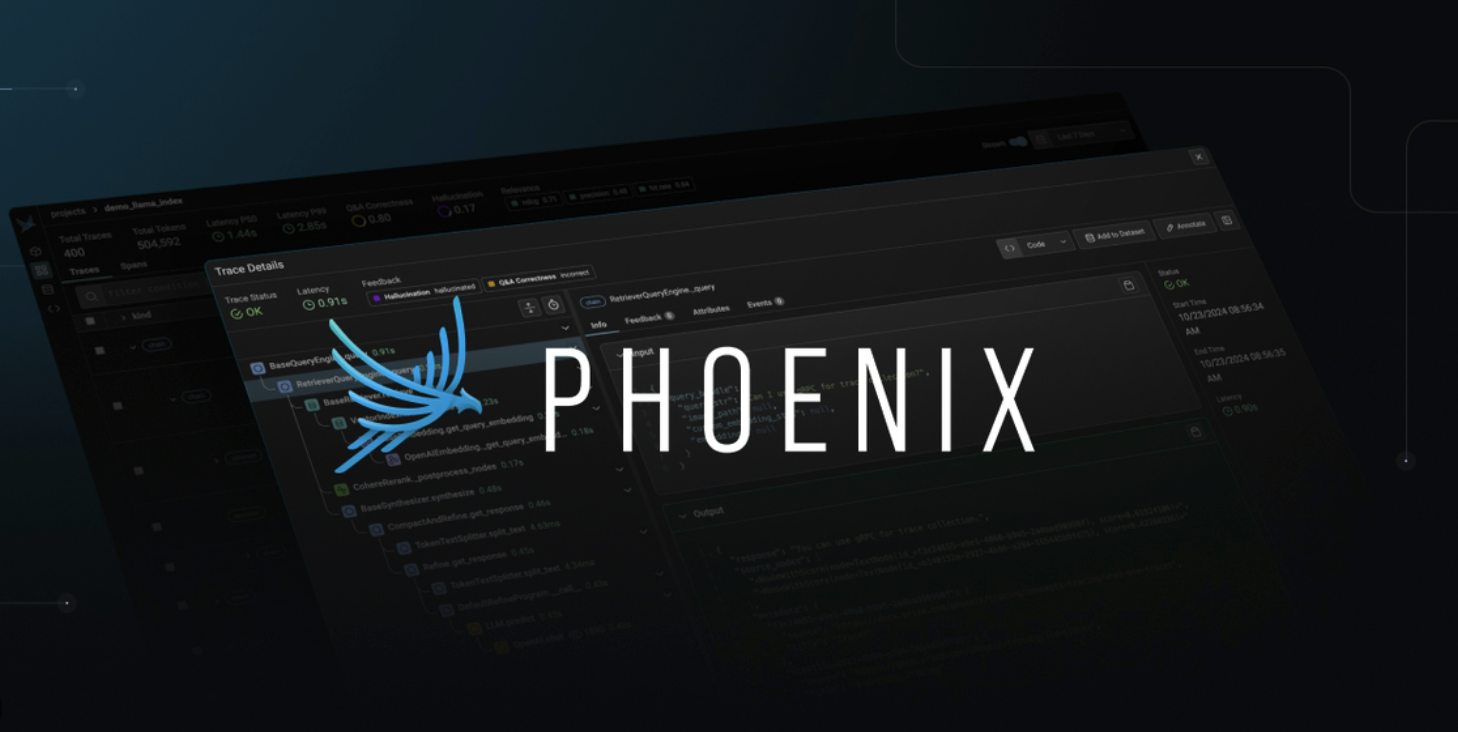

## Import Modules

In [1]:
#import environment file
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# text structure
from typing import Annotated
from typing_extensions import TypedDict
from typing import List, Union, Callable
from pydantic import BaseModel, Field
from urllib.parse import quote

# datetime
from datetime import datetime, timezone
import time
import uuid

# LangGraph graph def
from langgraph.graph import MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# Messages
from langchain_core.messages import AIMessage, HumanMessage

# Claude integration
from langchain_anthropic import ChatAnthropic

# creating ReAct agents with Supervisor architecture
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

# memory
from langgraph.checkpoint.memory import MemorySaver

# Define Tavily Search + Wiki Tools
from langchain_core.tools import Tool
from langchain.tools import tool
from langchain_community.tools.tavily_search.tool import TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper

# pandas
import pandas as pd

# OpenTelemetry
from openinference.instrumentation.anthropic import AnthropicInstrumentor
from openinference.instrumentation.langchain import LangChainInstrumentor
from opentelemetry.trace import Status, StatusCode
from opentelemetry import trace
from openinference.semconv.trace import SpanAttributes
from opentelemetry.trace import Status, StatusCode
from openinference.instrumentation import TracerProvider

# jupyter finessing
from IPython.display import Image, display, Markdown
import warnings
warnings.filterwarnings('ignore')

# needed for concurrent evals in notebook envs
import nest_asyncio
nest_asyncio.apply() 

# Phoenix
import phoenix as px
from phoenix.trace import SpanEvaluations
from phoenix.experiments import evaluate_experiment, run_experiment
from phoenix.otel import register
px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://arize.com/docs/phoenix


### Initialize Phoenix Tracer 👀

In [2]:
# configure the Phoenix tracer
tracer_provider = register(
  project_name="langgraph-antrhopic-tavily-agent",
  # auto_instrument=True # Auto-instrument your app based on installed OI dependencies
)
LangChainInstrumentor(tracer_provider=tracer_provider).instrument(skip_dep_check=True)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: langgraph-antrhopic-tavily-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [3]:
# (session := px.launch_app()).view()

# Model Initialization 🎈

In [4]:
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
if not anthropic_api_key:
    print("ANTHROPIC_API_KEY environment variable not set.")

In [5]:
MODEL = 'claude-3-7-sonnet-20250219'
# 'claude-4-sonnet-20250514'
# 'claude-opus-4-20250514'

In [6]:
claude = ChatAnthropic(
    model_name=MODEL,
    temperature=1,
    max_tokens=2000,
    
    # Enable thinking with budget_tokens as required by API  
    thinking={"type": "enabled", "budget_tokens": 1024},
    
    # Enable interleaved thinking for better tool use and reasoning
    extra_headers={
        "anthropic-beta": "interleaved-thinking-2025-05-14"
    },
    
    # Enable keep-alive as recommended by Anthropic
    timeout=300.0,  # 5 minute timeout
)

## Define Tools ✨

### 1️⃣ Tavily Search

In [7]:
tavily_api_key = os.getenv("TAVILY_API_KEY")
if not tavily_api_key:
    print("TAVILY_API_KEY environment variable not set.")

In [8]:
def create_tavily_search_tool(tavily_api_key):
    """
    Create the Tavily search tool with token management.
    Args:
        tavily_api_key: API key for Tavily
    Returns:
        Configured search tool or None if failed
    """
    try:
        def tavily_search(query, *args, **kwargs):
            
            try:
                print(f"Making Tavily API call for: {query[:50]}...")
                results = TavilySearchResults(api_key=tavily_api_key,
                                             # k=1,
                                             include_raw_content=False,
                                             include_images=False,
                                             include_answer=True,
                                             max_results=1,
                                             search_depth="basic")(query, *args, **kwargs)
                
                return results
                
            except Exception as e:
                print(f"Error in Tavily search: {e}")
                
                return error_result

        search_tool = Tool(
            name="tavily_search_results",
            func=tavily_search,
            description=
            "Search the web for current information. Useful for questions about current events or trending topics."
        )

        print("Successfully initialized Tavily Search with token management")
        return search_tool

    except Exception as e:
        print(f"Failed to initialize Tavily Search: {e}")
        return None

### 2️⃣ DateTime Tool

In [9]:
@tool
def get_current_datetime() -> str:
    """
    Get the current date and time in a user-friendly format.
    
    Returns:
        str: Current date and time in format "Friday, May 23, 2025 at 12:45 PM EST"
    
    Use this tool when:
    - User asks about current date, time, or "today"
    - User mentions "this week", "next week", "this month", etc.
    - User asks about weather forecasts or current events
    - Any time-sensitive queries that need current context
    """
    try:
        # Get current datetime in UTC
        now_utc = datetime.now(timezone.utc)
        
        # Format for user display
        formatted_date = now_utc.strftime("%A, %B %d, %Y at %I:%M %p UTC")
        
        return f"Current date and time: {formatted_date}"
        
    except Exception as e:
        error_msg = f"Error getting current datetime: {str(e)}"
        print(error_msg)
        return error_msg

### 3️⃣ Wiki Tool

In [10]:
def create_wikipedia_tool():
    """
    Create a Wikipedia search tool.

    Returns:
        Configured Wikipedia tool or None if failed
    """
    try:
        api_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=3000)

        # Wrap the Wikipedia run to provide error handling, token management, and caching
        def wiki_query_with_handling(query):
            # Input validation
            if not query or not isinstance(query, str):
                return "Invalid query: Please provide a valid search term."
            
            # Sanitize query - remove potentially problematic characters
            query = query.strip()
            if len(query) > 300:  # Align with WIKIPEDIA_MAX_QUERY_LENGTH
                query = query[:300]
            
            try:
                print(f"Making Wikipedia API call for: {query[:50]}...")
                result = api_wrapper.run(query)

                # Limit result size to avoid token issues
                if len(result) > 4000:
                    result = result[:4000] + "... [content truncated for brevity]"

                # Add Wikipedia source URL with proper encoding
                wiki_title = quote(query.replace(' ', '_'), safe='')
                wiki_url = f"https://en.wikipedia.org/wiki/{wiki_title}"
                result += f"\n\nSources:\n{wiki_url}"

                return result
                
            except Exception as e:
                error_result = "Wikipedia search encountered an error. Please try a different query or check your connection."
                print(f"Error in Wikipedia search: {e}")
                
                return error_result

        # Create the tool with our wrapped function
        wiki_tool = Tool(
            name="wikipedia_query_run",
            func=wiki_query_with_handling,
            description="""Searches Wikipedia for information about a given topic. 
            Use for historical, scientific, or general knowledge queries.
            """
        )

        print("Successfully initialized Wikipedia tool")
        return wiki_tool

    except Exception as e:
        print(f"Failed to initialize Wikipedia tool: {e}")
        return None

### Prompt Template 📝

In [11]:
def get_prompt():
    """
    Returns an enhanced prompt for the ReACT agent that coordinates between multiple tools.
    Include special instructions for handling content.
    """
    return """
    You're an advanced AI agent with expert access to Wikipedia and Tavily Search.
    You also have expert access to current Datetime information.
    Use tool calls when its most appropriate.
    Your goal is to analyze each user query and to provide comprehensive, accurate, and helpful responses.

    RESPONSE GUIDELINES:
    - **Summarize, Don't Recite Raw Data:** When a tool (like Web Search or Wikipedia) returns information, DO NOT output the raw data (e.g., JSON, long text blocks, lists of objects) directly to the user. Your primary task is to SYNTHESIZE and SUMMARIZE this information into a concise, coherent, and human-readable narrative.
    - **User-Facing Text Only:** Your final response to the user must be plain, natural language. It should not contain any internal thoughts, raw API responses, or debugging information.
    - **Handle Tool Errors Gracefully:** If a tool fails or returns an error, do not expose the raw error message. Inform the user politely (e.g., "I couldn't retrieve that information right now. Would you like me to try a different approach?").
    - **Clarity and Conciseness:** Provide clear and concise answers. Avoid jargon where possible, or explain it if necessary.

    SEARCH INSTRUCTIONS
        For current facts, news, or information that needs up-to-date sources, search the web.
        - Use for: Recent events, current facts, market data, news, product reviews.
        - EXAMPLE: "I'll search the web for information on that".
        - For Web searches: Use the tavily_search_results tool.

    WIKIPEDIA INSTRUCTIONS
        Search Wikipedia for the user's query and summarize the results.
        - Use for: Historical information, definitions, established concepts, biographies.
        - For Wikipedia searches: Use the wikipedia_query_run tool.
        - EXAMPLE: "I'll search Wikipedia for that information" followed by using wikipedia_query_run(query="your search term").
    
    
    **IMPORTANT - TIME-SENSITIVE QUERIES:**
    For queries involving current dates, time, weather, recent events, or relative time references ("this week", "next week", "today", "recently", etc.), ALWAYS get the current date first using get_current_date_simple() before making search queries. This ensures search results are contextualized with the correct timeframe and avoids confusion from your knowledge cutoff date.
    """

## Initialize Tools ✅ 

In [12]:
# 2. Initialize the tools properly by calling the factory functions
def initialize_tools():
    """Initialize all tools and return them as a list"""
    tools = []
    
    # Initialize Tavily search tool
    if tavily_api_key:
        tavily_tool = create_tavily_search_tool(tavily_api_key)
        if tavily_tool:
            tools.append(tavily_tool)
            print("✅ Tavily search tool initialized")
        else:
            print("❌ Failed to initialize Tavily search tool")
    else:
        print("⚠️ Tavily API key not found, skipping Tavily tool")
    
    # Initialize Wikipedia tool
    wiki_tool = create_wikipedia_tool()
    if wiki_tool:
        tools.append(wiki_tool)
        print("✅ Wikipedia tool initialized")
    else:
        print("❌ Failed to initialize Wikipedia tool")
    
    # Add datetime tool
    tools.append(get_current_datetime)
    print("✅ DateTime tool initialized")
    
    return tools

# 3. Initialize tools
available_tools = initialize_tools()

print(f"\n🎯 Agent created with {len(available_tools)} tools:")
for tool in available_tools:
    if hasattr(tool, 'name'):
        print(f"   - {tool.name}")
    else:
        print(f"   - {tool}")

Successfully initialized Tavily Search with token management
✅ Tavily search tool initialized
Successfully initialized Wikipedia tool
✅ Wikipedia tool initialized
✅ DateTime tool initialized

🎯 Agent created with 3 tools:
   - tavily_search_results
   - wikipedia_query_run
   - get_current_datetime


## Create First ReAct Agent 🤖

In [13]:
agent_one = create_react_agent(
    model=claude,
    tools=available_tools,
    name="expert_sme",
    prompt=get_prompt(),

    # add Memory
    checkpointer=MemorySaver()
)

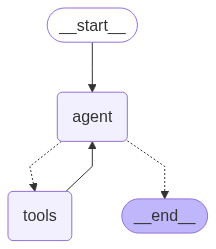

In [14]:
display(Image(agent_one.get_graph().draw_mermaid_png()))

## ❓Questions with Multiple Tool Runs

In [15]:
def user_agent_trace(query):
    """
    Break down user / agent interaction trace into streams for surface-level observability.
    """
    _thread_counter = 0
    
    # Get tracer (ensure Phoenix is set up first)
    tracer = trace.get_tracer(__name__)
    
    # Auto-increment thread_id
    _thread_counter += 1
    thread_id = f"thread_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{_thread_counter}"

    # Define config with thread_id
    config = {
        "configurable": {
            "thread_id": thread_id
        },
        "recursion_limit": 50,
        "max_execution_time": 300,  # 5 min timeout
    }
    
    print(f"\n🤔 USER QUERY: {query}")
    print(f"🔗 Thread ID: {thread_id}")
    print("=" * 80)
    
    step_counter = 1
    reasoning_parts = []
    
    for msg, metadata in agent_one.stream(
        {"messages": [HumanMessage(content=query)]}, 
        config, 
        stream_mode="messages"
    ):
        # safely extract message type
        msg_type = getattr(msg, 'type', None) 
        
        # Handle HumanMessage (user input)
        if isinstance(msg, HumanMessage):
            continue  # Skip user messages in trace
        
        # Handle AIMessage (assistant responses)
        elif hasattr(msg, 'content') and msg.content:
            
            if isinstance(msg.content, list):
                for block in msg.content:
                    if isinstance(block, dict):
                        block_type = block.get('type', '')
                        
                        # Reasoning/Thinking
                        if block_type == 'thinking':
                            reasoning_parts.append(block.get('thinking', ''))
                        
                        # Agent speech/explanation
                        elif block_type == 'text':
                            # Show accumulated reasoning first
                            if reasoning_parts:
                                reasoning_text = ''.join(reasoning_parts).strip()
                                if reasoning_text:
                                    print(f"\n🧠 STEP {step_counter} - AGENT REASONING:")
                                    print(f"   {reasoning_text}")
                                    reasoning_parts = []
                                    step_counter += 1
                            
                            text_content = block.get('text', '').strip()
                            if text_content:
                                print(f"\n🤖 ASSISTANT RESPONSE:")
                                print(f"   {text_content}")
                        
                        # Tool usage
                        elif block_type == 'tool_use':
                            tool_name = block.get('name', '')
                            tool_input = block.get('input', {})
                            
                            print(f"\n🔧 TOOL CALL:")
                            print(f"   Using: {tool_name}")
                            if tool_input:
                                print(f"   Parameters: {tool_input}")
            
            # Handle direct string responses
            elif isinstance(msg.content, str):
                content = msg.content.strip()
                if content:
                    print(f"\n🤖 ASSISTANT:")
                    print(f"   {content}")
        
        # Handle ToolMessage (tool results)
        elif msg_type == 'tool':
            print(f"\n📊 TOOL RESULT:")
            content = getattr(msg, 'content', '')
            # Truncate long tool results for readability
            if len(content) > 300:
                print(f"   {content[:300]}...")
            else:
                print(f"   {content}")
    
    # Show any final reasoning
    if reasoning_parts:
        reasoning_text = ''.join(reasoning_parts).strip()
        if reasoning_text:
            print(f"\n🧠 FINAL REASONING:")
            print(f"   {reasoning_text}")
    
    print(f"\n✅ QUERY COMPLETED")
    print("=" * 80)

In [16]:
queries = [
    "what's the weather like in Queens today?", 
    "Who was the King of the Ancient Greek Gods?",
    "What's the best method to evaluate an LLM?"
]

In [17]:
print("=" * 80)
user_agent_trace(queries[0])


🤔 USER QUERY: what's the weather like in Queens today?
🔗 Thread ID: thread_20250720_143818_1

🧠 STEP 1 - AGENT REASONING:
   The user is asking about the weather in Queens today. This is a time-sensitive query that requires current information. I should first get the current date and time, and then search for weather information for Queens (likely Queens, New York).

1. I'll get the current date using get_current_datetime()
2. Then I'll search for the current weather in Queens using tavily_search_results

🤖 ASSISTANT RESPONSE:
   To answer your question about today

🤖 ASSISTANT RESPONSE:
   's weather in Queens, I'll

🤖 ASSISTANT RESPONSE:
   need to check the current date and search

🤖 ASSISTANT RESPONSE:
   for the latest weather information

🤖 ASSISTANT RESPONSE:
   .

🔧 TOOL CALL:
   Using: get_current_datetime

🤖 ASSISTANT:
   Current date and time: Sunday, July 20, 2025 at 06:38 PM UTC

🤖 ASSISTANT RESPONSE:
   Now

🤖 ASSISTANT RESPONSE:
   I'll search for the

🤖 ASSISTANT RESPO

In [18]:
print("=" * 80)
user_agent_trace(queries[1])


🤔 USER QUERY: Who was the King of the Ancient Greek Gods?
🔗 Thread ID: thread_20250720_143839_1

🧠 STEP 1 - AGENT REASONING:
   The user is asking about the king of the Ancient Greek gods, which is a question about mythology and historical knowledge. This is a factual question about established mythology, which would be well-covered in Wikipedia. I should use the Wikipedia tool to search for information about Greek mythology or specifically about the king of the Greek gods.

🤖 ASSISTANT RESPONSE:
   I'll search Wikipedia for information about the king

🤖 ASSISTANT RESPONSE:
   of the Ancient Greek gods.

🔧 TOOL CALL:
   Using: wikipedia_query_run
Making Wikipedia API call for: Zeus king of ancient Greek gods...

🤖 ASSISTANT:
   Page: Zeus
Summary: Zeus (, Ancient Greek: Ζεύς) is the chief deity of the Greek pantheon. He is a sky and thunder god in ancient Greek religion and mythology, who rules as king of the gods on Mount Olympus.
Zeus is the child of Cronus and Rhea, the youngest of

In [19]:
print("=" * 80)
user_agent_trace(queries[2])


🤔 USER QUERY: What's the best method to evaluate an LLM?
🔗 Thread ID: thread_20250720_143857_1

🧠 STEP 1 - AGENT REASONING:
   The user is asking about the best method to evaluate an LLM (Large Language Model). This is a technical question about AI model evaluation, which would benefit from current information since LLM evaluation methods are evolving. Let me search for current information on LLM evaluation methods.

🤖 ASSISTANT RESPONSE:
   To answer your question about the best methods to evaluate Large

🤖 ASSISTANT RESPONSE:
   Language Models (LLMs), I'll search

🤖 ASSISTANT RESPONSE:
   for the most current information on this topic.

🔧 TOOL CALL:
   Using: tavily_search_results
Making Tavily API call for: best methods to evaluate LLM performance benchmark...

🤖 ASSISTANT:
   [{"title": "Evaluating LLM systems: Metrics, challenges, and best practices", "url": "https://medium.com/data-science-at-microsoft/evaluating-llm-systems-metrics-challenges-and-best-practices-664ac25be7e5", 

# Start Evals 🦾

## Download Span Data from Phoenix server 👍

In [20]:
# Download all spans from a specific project
spansDF = px.Client().get_spans_dataframe(project_name='langgraph-antrhopic-tavily-agent')
spansDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 8ef86480dfb57180 to 71aed918e5d86085
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   name                                   80 non-null     object             
 1   span_kind                              80 non-null     object             
 2   parent_id                              74 non-null     object             
 3   start_time                             80 non-null     datetime64[ns, UTC]
 4   end_time                               80 non-null     datetime64[ns, UTC]
 5   status_code                            80 non-null     object             
 6   status_message                         80 non-null     object             
 7   events                                 80 non-null     object             
 8   context.span_id                        80 non-null     object       

In [21]:
# Filter for spans that have tool calls
spansDF = spansDF[spansDF['span_kind'] == "TOOL"].copy()
spansDF = spansDF.dropna(axis=1, how='all').copy()
spansDF = spansDF[spansDF['attributes.input.value'] != '{}'] [['attributes.input.value',
                                                               'attributes.output.value', 
                                                               'attributes.tool.description']].copy()
spansDF = spansDF.rename(columns={
    'attributes.input.value': 'question',
    'attributes.output.value': 'tool_call',
    'attributes.tool.description': 'tool_definitions'
}).copy()

In [22]:
spansDF

,question,tool_call,tool_definitions
context.span_id,,,
451da267850cc930,"{'__arg1': 'current weather in Queens, New Yor...","{""output"": ""content='[{\""title\"": \""Weather in...",Search the web for current information. Useful...
b67e7e35a442a96e,"current weather in Queens, New York today July...","{""output"": [{""title"": ""Weather in Queens, New ...","A search engine optimized for comprehensive, a..."
2aba681f87e03376,{'__arg1': 'Zeus king of ancient Greek gods'},"{""output"": ""content='Page: Zeus\\nSummary: Zeu...",Searches Wikipedia for information about a giv...
78c5b912b40744f6,{'__arg1': 'best methods to evaluate LLM perfo...,"{""output"": ""content='[{\""title\"": \""Evaluating...",Search the web for current information. Useful...
e95b9442aa16aaad,{'__arg1': 'Large language model evaluation me...,"{""output"": ""content=\""Page: Large language mod...",Searches Wikipedia for information about a giv...
30b15cc91c6dd615,{'__arg1': 'Evaluation methods for language mo...,"{""output"": ""content=\""Page: Language model\\nS...",Searches Wikipedia for information about a giv...
bd067f49a159928f,{'__arg1': 'LLM evaluation benchmarks MMLU HEL...,"{""output"": ""content='[{\""title\"": \""MMLU - Hol...",Search the web for current information. Useful...
daffae95a9dfaa32,best methods to evaluate LLM performance bench...,"{""output"": [{""title"": ""Evaluating LLM systems:...","A search engine optimized for comprehensive, a..."
71aed918e5d86085,LLM evaluation benchmarks MMLU HELM Holistic E...,"{""output"": [{""title"": ""MMLU - Holistic Evaluat...","A search engine optimized for comprehensive, a..."


## Agent Function Calling Prompt Template

The Agent Function Call eval can be used to determine how well a model selects a tool to use, extracts the right parameters from the user query, and generates the tool call code.

Parameters:

    df - a dataframe of cases to evaluate. The dataframe must have these columns to match the default template:

        question - the query made to the model. If you've exported spans from Phoenix to evaluate, this will the llm.input_messages column in your exported data.

        tool_call - information on the tool called and parameters included. If you've exported spans from Phoenix to evaluate, this will be the llm.function_call column in your exported data.

Source: https://arize.com/docs/phoenix/evaluation/how-to-evals/running-pre-tested-evals/tool-calling-eval

In [23]:
TOOL_CALLING_PROMPT_TEMPLATE = """
You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and that no outside information not present in the question was used
in the generated question.

    [Tool Definitions]: {tool_definitions}
"""

In [24]:
from phoenix.evals import (
    TOOL_CALLING_PROMPT_RAILS_MAP,
    TOOL_CALLING_PROMPT_TEMPLATE,
    AnthropicModel,
    llm_classify,
)

# the rails object will be used to snap responses to "correct" 
# or "incorrect"
rails = list(TOOL_CALLING_PROMPT_RAILS_MAP.values())
model = AnthropicModel(
    model=MODEL,
    temperature=0,
    max_tokens=2000
)

# Loop through the specified dataframe and run each row 
# through the specified model and prompt. llm_classify
# will run requests concurrently to improve performance.
tool_call_evaluations = llm_classify(
    dataframe=spansDF,
    template=TOOL_CALLING_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True
)

I0000 00:00:1753036789.421299   78245 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


llm_classify |          | 0/9 (0.0%) | ⏳ 00:00<? | ?it/s

In [25]:
tool_call_evaluations

,label,explanation,exceptions,execution_status,execution_seconds
context.span_id,,,,,
451da267850cc930,correct,EXPLANATION:\nLet me analyze this step by step...,[],COMPLETED,8.068451
b67e7e35a442a96e,correct,EXPLANATION:\n\nLet me analyze this step by st...,[],COMPLETED,7.170747
2aba681f87e03376,correct,EXPLANATION: \n\nLet me analyze this step by s...,[],COMPLETED,7.860547
78c5b912b40744f6,correct,EXPLANATION:\n\nLet me analyze this step by st...,[],COMPLETED,8.675647
e95b9442aa16aaad,incorrect,EXPLANATION:\n\nLet me analyze this step by st...,[],COMPLETED,8.693995
30b15cc91c6dd615,incorrect,EXPLANATION:\nLet me analyze this step by step...,[],COMPLETED,10.328543
bd067f49a159928f,correct,EXPLANATION:\nLet me analyze this step by step...,[],COMPLETED,8.072908
daffae95a9dfaa32,correct,EXPLANATION:\n\nLet me analyze this step by st...,[],COMPLETED,8.692154
71aed918e5d86085,correct,I need to evaluate whether the tool call would...,[],COMPLETED,13.987649


In [58]:
tool_call_evaluations[tool_call_evaluations.index == '451da267850cc930']['explanation'].values

array(['EXPLANATION:\nLet me analyze this step by step:\n\n1. The question asks about "current weather in Queens, New York today July 20, 2025"\n2. The tool called is tavily_search_results, which is a web search tool\n3. The search returned weather information for Queens Village, New York for July 20, 2025, showing:\n   - Temperature: 84.9°F (29.4°C)\n   - Condition: Partly cloudy\n   - Other weather details like humidity, wind speed, etc.\n\n4. Looking at the tool definition provided: "Search the web for current information. Useful for questions about current events or trending topics."\n5. Weather information is considered current information, and the search tool successfully retrieved weather data for the specific date and location requested.\n6. The tool call included the correct parameters extracted from the question (searching for weather in Queens, New York for the specified date).\n7. No outside information not present in the question was used in generating the search.\n\nThe w

In [59]:
spansDF[spansDF.index == '451da267850cc930']['tool_call'].values

array(['{"output": "content=\'[{\\"title\\": \\"Weather in Queens, New York\\", \\"url\\": \\"https://www.weatherapi.com/\\", \\"content\\": \\"{\\\\\'location\\\\\': {\\\\\'name\\\\\': \\\\\'Queens Village\\\\\', \\\\\'region\\\\\': \\\\\'New York\\\\\', \\\\\'country\\\\\': \\\\\'United States of America\\\\\', \\\\\'lat\\\\\': 40.7267, \\\\\'lon\\\\\': -73.7419, \\\\\'tz_id\\\\\': \\\\\'America/New_York\\\\\', \\\\\'localtime_epoch\\\\\': 1753036724, \\\\\'localtime\\\\\': \\\\\'2025-07-20 14:38\\\\\'}, \\\\\'current\\\\\': {\\\\\'last_updated_epoch\\\\\': 1753036200, \\\\\'last_updated\\\\\': \\\\\'2025-07-20 14:30\\\\\', \\\\\'temp_c\\\\\': 29.4, \\\\\'temp_f\\\\\': 84.9, \\\\\'is_day\\\\\': 1, \\\\\'condition\\\\\': {\\\\\'text\\\\\': \\\\\'Partly cloudy\\\\\', \\\\\'icon\\\\\': \\\\\'//cdn.weatherapi.com/weather/64x64/day/116.png\\\\\', \\\\\'code\\\\\': 1003}, \\\\\'wind_mph\\\\\': 10.7, \\\\\'wind_kph\\\\\': 17.3, \\\\\'wind_degree\\\\\': 220, \\\\\'wind_dir\\\\\': \\\\\'SW\\\

In [61]:
tool_call_evaluations[tool_call_evaluations.index == 'e95b9442aa16aaad']['explanation'].values

array(['EXPLANATION:\n\nLet me analyze this step by step:\n\n1. The question is asking about "Large language model evaluation methods" - specifically methods for evaluating LLMs.\n\n2. The tool called is Wikipedia, which is appropriate for seeking information about technical topics like LLM evaluation.\n\n3. However, when I examine the content returned by the Wikipedia query, I notice that it contains information about:\n   - What large language models (LLMs) are\n   - What language models are in general\n   - What foundation models are\n\n4. Critically, the returned content does not contain information about "evaluation methods" for large language models, which was the specific focus of the question.\n\n5. While the information is related to LLMs in general, it doesn\'t address the evaluation methods aspect of the question at all.\n\n6. The Wikipedia query appears to have returned general information about LLMs rather than specifically about methods to evaluate them.\n\nSince the tool

In [62]:
# write annotations back to Phoenix
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval", dataframe=tool_call_evaluations),
)

# Start Agent Path Convergence 👉👈

# More Data !!! 🙏 Chris Nolan

In [35]:
# load synthetic data about Chris Nolan's birthplace
nolanDF = pd.read_csv('chris_nolan/question_variations_analysis.csv')

In [36]:
nolanDF.head()

,id,question,target_entity,target_attribute,answer,question_pattern,phrasing_style,complexity_markers,expected_tools,multi_hop,...,variation_number,base_pattern,linguistic_complexity,question_length,question_words,requires_current_data,multi_hop_type,domain,consistency_test,expected_answer
0,var_001,What is the birthplace of Christopher Nolan?,Christopher Nolan,birthplace,"London, England",what_is_birthplace,formal_direct,"['what is', 'birthplace']",['wikipedia_search'],False,...,1,person_birthplace_lookup,2,44,7,False,single_lookup,biographical_facts,True,"London, England"
1,var_002,Where was Christopher Nolan born?,Christopher Nolan,birthplace,"London, England",where_was_born,simple_direct,"['where', 'born']",['wikipedia_search'],False,...,2,person_birthplace_lookup,2,33,5,False,single_lookup,biographical_facts,True,"London, England"
2,var_003,In which city was Christopher Nolan born?,Christopher Nolan,birthplace,"London, England",in_which_city_born,formal_specific,"['in which city', 'born']",['wikipedia_search'],False,...,3,person_birthplace_lookup,2,41,7,False,single_lookup,biographical_facts,True,"London, England"
3,var_004,What's Christopher Nolan's place of birth?,Christopher Nolan,birthplace,"London, England",place_of_birth,casual_possessive,"[""what's"", 'place of birth']",['wikipedia_search'],False,...,4,person_birthplace_lookup,2,42,6,False,single_lookup,biographical_facts,True,"London, England"
4,var_005,From where does Christopher Nolan originate?,Christopher Nolan,birthplace,"London, England",from_where_originate,formal_origin,"['from where', 'originate']",['wikipedia_search'],False,...,5,person_birthplace_lookup,2,44,6,False,single_lookup,biographical_facts,True,"London, England"


In [37]:
nolanDF['question'].values

array(['What is the birthplace of Christopher Nolan?',
       'Where was Christopher Nolan born?',
       'In which city was Christopher Nolan born?',
       "What's Christopher Nolan's place of birth?",
       'From where does Christopher Nolan originate?',
       'Which location gave birth to Christopher Nolan?',
       'What is the native city of Christopher Nolan?',
       'Where in the world was Christopher Nolan born?',
       'Can you tell me where Christopher Nolan was born?',
       'What city and country did Christopher Nolan come from originally?'],
      dtype=object)

In [38]:
nolanDF = px.Client().upload_dataset(
    dataframe=nolanDF, dataset_name="convergence_questions", input_keys=["question"]
)

📤 Uploading dataset...
💾 Examples uploaded: http://localhost:6006/datasets/RGF0YXNldDox/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246MQ==


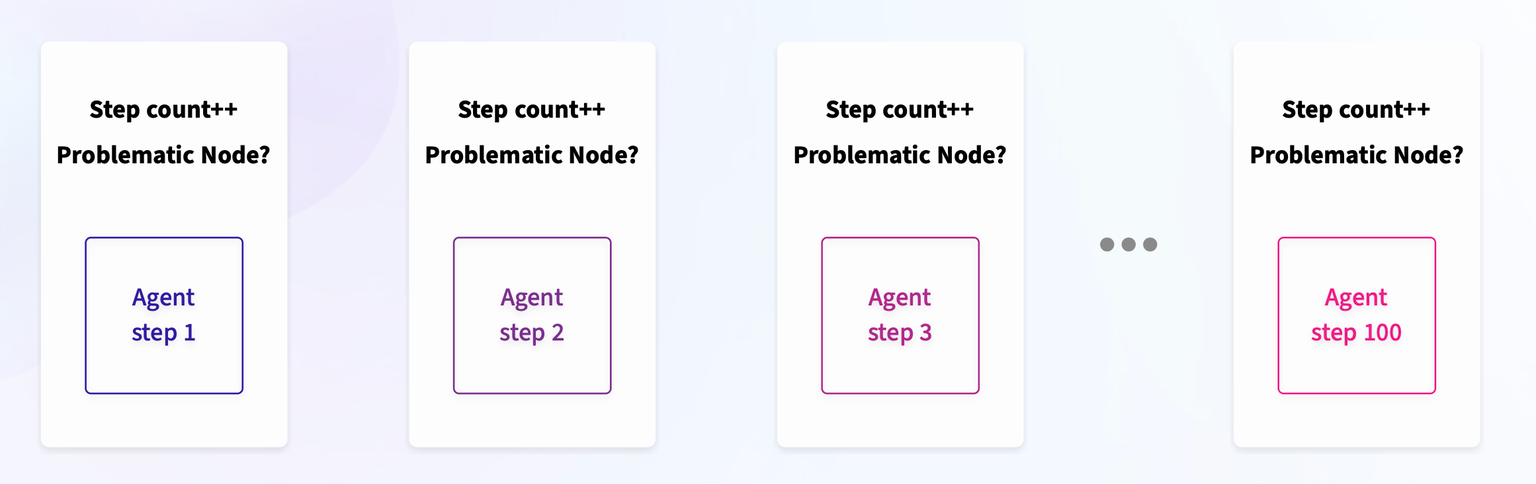

When your agents take multiple steps to get to an answer or resolution, it's important to evaluate the pathway it took to get there. You want most of your runs to be consistent and not take unnecessarily frivolous or wrong actions.

One way of doing this is to calculate convergence:

    Run your agent on a set of similar queries

    Record the number of steps taken for each

    Calculate the convergence score: avg(minimum steps taken / steps taken for this run)

This will give a convergence score of 0-1, with 1 being a perfect score.

### Custom script to compute Convergence for LangGraph
Source: https://colab.research.google.com/github/Arize-ai/phoenix/blob/main/tutorials/evals/evaluate_agent.ipynb#scrollTo=xudm03E-1ax_

In [39]:
def format_message_steps(messages):
    """
    Convert LangGraph messages into a readable format showing ReAct steps.
    """
    steps = []
    reasoning_count = 0
    action_count = 0
    
    for message in messages:
        content = getattr(message, 'content', '') if hasattr(message, 'content') else message.get('content', '')

        # checks if message object has content
        if hasattr(message, 'type'):
            message_type = message.type
        else:
            message_type = message.get('type', 'unknown')
            
        if message_type == "human":
            steps.append(f"User: {content}")
        elif message_type == "system":
            steps.append("System: Context provided")
        elif message_type == "ai":
            if hasattr(message, 'tool_calls') and message.tool_calls:
                action_count += 1
                for tool_call in message.tool_calls:
                    tool_name = tool_call.get("name", "unknown_tool")            # check for malformed tool calls instead of returning None
                    steps.append(f"Action {action_count}: Called '{tool_name}'")
            elif content:
                reasoning_count += 1
                steps.append(f"Thought {reasoning_count}: {content}")
        elif message_type == "tool":
            observation = content[:200] + "..." if len(content) > 200 else content
            steps.append(f"Observation: {observation}")
    
    return "\n".join(steps)

# Track agent execution and convergence with enhanced metrics
def run_agent_and_track_path(example):
    """
    Run LangGraph agent and track convergence metrics with complete message breakdown.
    """
    question = example.input.get("question")
    print(f"Running agent for: {question}")
    
    # Existing LangGraph invocation with checkpoint config
    try:
        # Add checkpoint configuration for LangGraph
        config = {
            "configurable": {
                "thread_id": f"eval_{hash(question) % 10000}",  # Unique thread per question
            }
        }
        result = agent_one.invoke({"messages": [("user", question)]}, config=config)
        messages = result.get("messages", [])
        
        # Calculate all message type counts
        human_messages = sum(1 for msg in messages 
                           if getattr(msg, 'type', None) == 'human')
        
        system_messages = sum(1 for msg in messages 
                            if getattr(msg, 'type', None) == 'system')
        
        tool_messages = sum(1 for msg in messages 
                          if getattr(msg, 'type', None) == 'tool')
        
        # AI message breakdown
        reasoning_steps = sum(1 for msg in messages 
                            if getattr(msg, 'type', None) == 'ai' 
                            and getattr(msg, 'content', '') 
                            and not getattr(msg, 'tool_calls', None))
        
        action_steps = sum(1 for msg in messages 
                          if getattr(msg, 'type', None) == 'ai' 
                          and getattr(msg, 'tool_calls', None))
        
        # Total AI messages
        total_ai_messages = reasoning_steps + action_steps
        
        # Verify counts add up
        path_length = len(messages)
        # Note: total_ai_messages = reasoning_steps + action_steps
        calculated_total = human_messages + system_messages + tool_messages + total_ai_messages
        
        # Alternative calculation (should give same result):
        # calculated_total = human_messages + system_messages + tool_messages + reasoning_steps + action_steps
        
        # Simple convergence check - has final answer and reasonable path length
        converged = (len(messages) > 0 and 
                    len(messages) < 20 and  # Not too many steps
                    any(getattr(msg, 'type', None) == 'ai' and 
                        getattr(msg, 'content', '') and 
                        not getattr(msg, 'tool_calls', None)
                        for msg in messages[-2:]))  # Has reasoning in final steps
        
        return {
            "converged": converged,
            "path_length": path_length,
            
            # Message type breakdown
            "human_messages": human_messages,
            "system_messages": system_messages,
            "tool_messages": tool_messages,
            "ai_messages": total_ai_messages,  # Sum of reasoning_steps + action_steps
            
            # AI message breakdown
            "reasoning_steps": reasoning_steps,
            "action_steps": action_steps,
            
            # Verification
            "count_verification": path_length == calculated_total,
            "count_mismatch": path_length - calculated_total if path_length != calculated_total else 0,
            
            # Original fields
            "messages": format_message_steps(messages),
            "question": question
        }
        
    except Exception as e:
        print(f"Error running agent: {e}")
        return {
            "converged": False,
            "path_length": 0,
            "error": str(e),
            "question": question
        }

# Run the convergence experiment
experiment = run_experiment(
    nolanDF,  # Your dataset
    run_agent_and_track_path,
    experiment_name="Chris_Nolan_ReAct_Convergence",
    experiment_description="Evaluating ReAct agent convergence with message breakdown",
)

🧪 Experiment started.
📺 View dataset experiments: http://localhost:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox


running tasks |          | 0/10 (0.0%) | ⏳ 00:00<? | ?it/s

Running agent for: What is the birthplace of Christopher Nolan?
Making Wikipedia API call for: Christopher Nolan birthplace...
Making Wikipedia API call for: Christopher Nolan...
Making Tavily API call for: Where was Christopher Nolan born birthplace...
Running agent for: Where was Christopher Nolan born?
Making Wikipedia API call for: Christopher Nolan birthplace...
Making Wikipedia API call for: Christopher Nolan...
Making Tavily API call for: Where was Christopher Nolan born London...
Running agent for: In which city was Christopher Nolan born?
Making Wikipedia API call for: Christopher Nolan...
Making Wikipedia API call for: Christopher Nolan early life...
Making Tavily API call for: Christopher Nolan film director born what city...
Running agent for: What's Christopher Nolan's place of birth?
Making Wikipedia API call for: Christopher Nolan birthplace...
Making Wikipedia API call for: Christopher Nolan...
Making Tavily API call for: Christopher Nolan place of birth...
Running agen

I0000 00:00:1753037274.396896   78245 chttp2_transport.cc:1188] ipv6:%5B::1%5D:4317: Got goaway [11] err=UNAVAILABLE:GOAWAY received; Error code: 11; Debug Text: ping_timeout {http2_error:11, grpc_status:14}


Making Tavily API call for: Christopher Nolan birthplace London childhood orig...
✅ Task runs completed.

🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Tasks Summary (07/20/25 02:48 PM -0400)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|           10 |       10 |          0 |


In [40]:
(8 + 10 + 10 + 6 + 8 + 4 + 8 + 10 + 10 + 8) / 10

8.2

### Q: What city and country did Christopher Nolan come from originally?
#### Path Length = 8
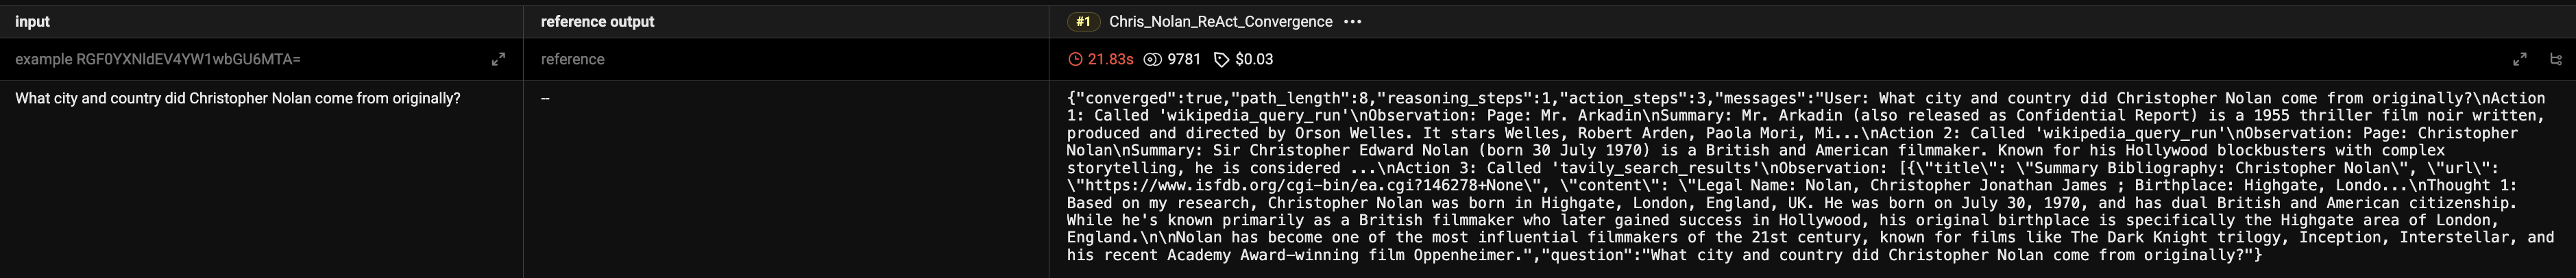

### Q: Can you tell me where Christopher Nolan was born?
#### Path Length = 10
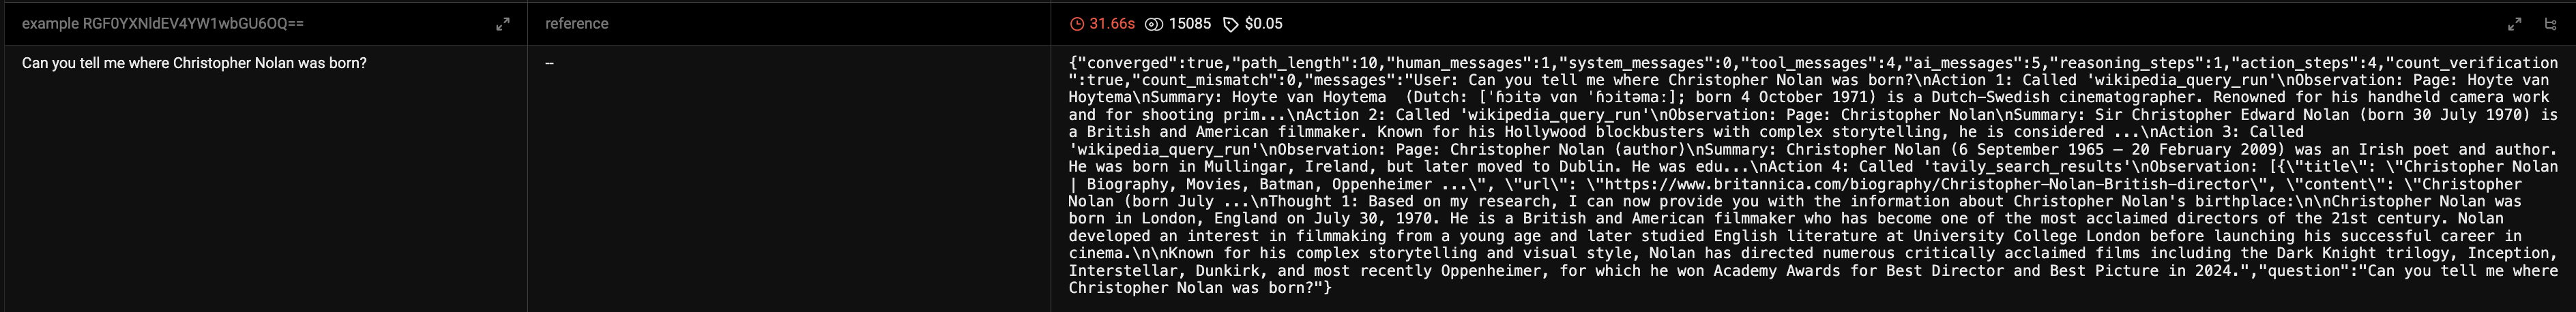

### Q: Where in the world was Christopher Nolan born?
#### Path Length = 10
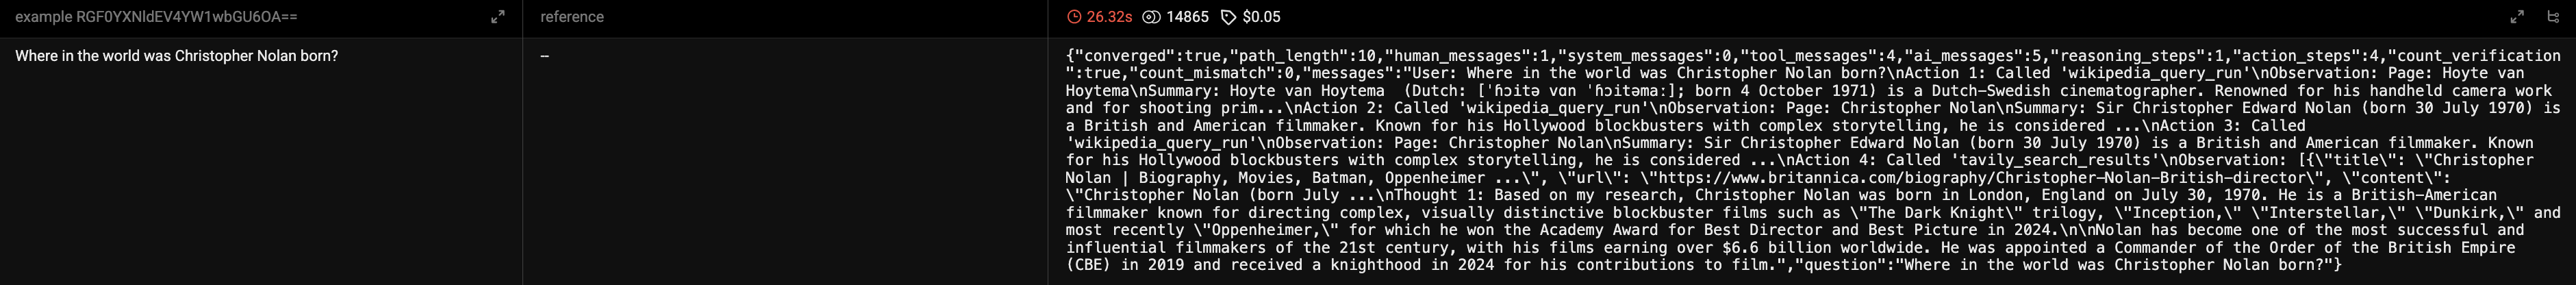

# Let's see if improving the prompt helps 🤔

In [41]:
def new_prompt():
    """
    Returns an enhanced prompt for the ReACT agent that coordinates between multiple tools.
    Include special instructions for handling content.
    """
    return """
    You're an advanced AI agent with expert access to Wikipedia and Tavily Search.
    You also have expert access to Current Datetime information.
    Use tool calls when its most appropriate.
    Your goal is to analyze each user query and to provide comprehensive, accurate, and helpful responses.

    RESPONSE GUIDELINES:
    - **Summarize, Don't Recite Raw Data:** When a tool (like Web Search or Wikipedia) returns information, DO NOT output the raw data (e.g., JSON, long text blocks, lists of objects) directly to the user. Your primary task is to SYNTHESIZE and SUMMARIZE this information into a concise, coherent, and human-readable narrative.
    - **User-Facing Text Only:** Your final response to the user must be plain, natural language. It should not contain any internal thoughts, raw API responses, or debugging information.
    - **Example of What NOT To Do (Weather Tool):**
        - User: "What's the weather in Queens?"
         - BAD AI Response: "[{{'location': {{'name': 'Queens Village', ...}}, 'current': {{'temp_f': 53.1, ...}} }}]"
    - **Example of What TO Do (Weather Tool):**
        - User: "What's the weather in Queens?"
        - GOOD AI Response: "Currently, it's 53°F and overcast in Queens Village, New York. The wind is blowing from the East at 14 mph."
    - **Handle Tool Errors Gracefully:** If a tool fails or returns an error, do not expose the raw error message. Inform the user politely (e.g., "I couldn't retrieve that information right now. Would you like me to try a different approach?").
    - **Clarity and Conciseness:** Provide clear and concise answers. Avoid jargon where possible, or explain it if necessary.

    SEARCH INSTRUCTIONS
        For current facts, news, or information that needs up-to-date sources, search the web.
        - Use for: Recent events, current facts, market data, news, product reviews.
        - EXAMPLE: "I'll search the web for information on that".
        - For Web searches: Use the tavily_search_results tool.

        SEARCH PROCESS:
        1. Analyze the query to identify key information needs.
        2. Formulate a precise search query focused on these needs.
        3. Execute search using the tavily_search_results tool.
        4. Analyze results for relevance, credibility, and recency.
        5. **CRITICAL: Synthesize the gathered information from the tool's output into a clear, human-readable summary. Do not output the raw tool response (e.g., JSON, lists of articles, or raw text snippets from the tool).**
        6. Formulate your response to the user based on this summary.
        7. Always include proper citations as per the CITATION GUIDELINES.

    WIKIPEDIA INSTRUCTIONS
        Search Wikipedia for the user's query and summarize the results.
        - Use for: Historical information, definitions, established concepts, biographies.
        - For Wikipedia searches: Use the wikipedia_query_run tool.
        - EXAMPLE: "I'll search Wikipedia for that information" followed by using wikipedia_query_run(query="your search term").
        
        WIKIPEDIA PROCESS:
        1. Analyze the query.
        2. Formulate a search term for Wikipedia.
        3. Execute the wikipedia_query_run tool.
        4. **CRITICAL: Synthesize the key information from Wikipedia into a human-readable summary. Do not output large blocks of raw text from Wikipedia.**
        5. Formulate your response to the user based on this summary.
        6. Cite Wikipedia as a source if used.

    FOR ALL TOOL CALLS:
    Always use the proper format when calling tools. Do not create invalid tool calls.
    1. After receiving tool results, analyze them and provide a clear, concise summary.
    2. Only call a tool once for a query unless you explicitly need more information.
    3. Always provide an actual response when you have enough information.
    
    **IMPORTANT - TIME-SENSITIVE QUERIES:**
    For queries involving current dates, time, weather, recent events, or relative time references ("this week", "next week", "today", "recently", etc.), ALWAYS get the current date first using get_current_date_simple() before making search queries. This ensures search results are contextualized with the correct timeframe and avoids confusion from your knowledge cutoff date.
    
    Examples requiring date context:
    - "What's the weather this week?" → Get date, then search "weather forecast [location] [current date]"
    - "Recent news about AI" → Get date, then search "AI news [current date]"
    - "Events next week in Miami" → Get date, then search "Miami events [calculated week]"
    """

In [42]:
## re-initiliaze Agent One
agent_one = create_react_agent(
    model=claude,
    tools=available_tools,
    name="expert_sme_with_new_prompt",
    prompt=new_prompt(),

    # add Memory
    checkpointer=MemorySaver()
)

In [43]:
# Re-run the convergence experiment
experiment = run_experiment(
    nolanDF,  # Your dataset
    run_agent_and_track_path,
    experiment_name="Chris_Nolan_ReAct_Convergence_v2",
    experiment_description="Evaluating ReAct agent convergence on Chris Nolan dataset with new prompt",
)

🧪 Experiment started.
📺 View dataset experiments: http://localhost:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy


running tasks |          | 0/10 (0.0%) | ⏳ 00:00<? | ?it/s

Running agent for: What is the birthplace of Christopher Nolan?
Making Wikipedia API call for: Christopher Nolan birthplace...
Making Wikipedia API call for: Christopher Nolan director...
Making Wikipedia API call for: Christopher Nolan...
Making Tavily API call for: Christopher Nolan birthplace where was he born...
Running agent for: Where was Christopher Nolan born?
Making Wikipedia API call for: Christopher Nolan birthplace...
Making Wikipedia API call for: Christopher Nolan...
Running agent for: In which city was Christopher Nolan born?
Making Wikipedia API call for: Christopher Nolan...
Making Tavily API call for: Christopher Nolan birthplace city...
Worker timeout, requeuing
Running agent for: In which city was Christopher Nolan born?
Running agent for: What's Christopher Nolan's place of birth?
Making Wikipedia API call for: Christopher Nolan...
Making Tavily API call for: Christopher Nolan birthplace where was he born...
Running agent for: From where does Christopher Nolan orig

In [44]:
(6 + 6 + 8 + 6 + 8 + 4 + 6 + 10 + 6 + 14) / 10

7.4

## Success! What An Improvement 👏👏👏 🎉

### Q: What city and country did Christopher Nolan come from originally?
#### Path Length = 6 (Prev. 8)
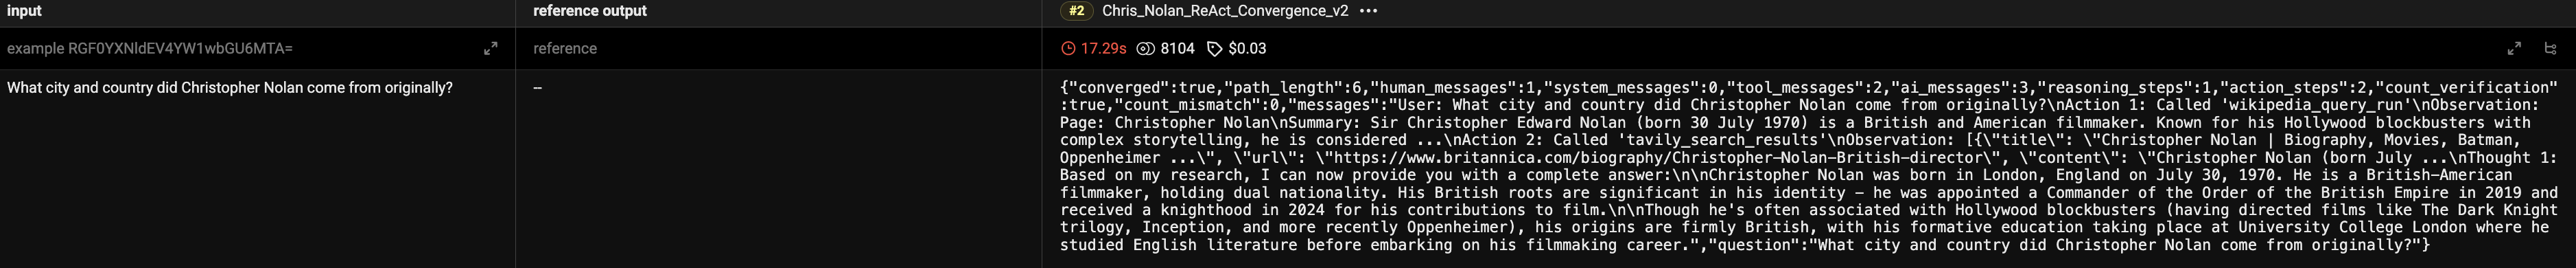

### Q: Can you tell me where Christopher Nolan was born?
#### Path Length = 6 (Prev. 10)
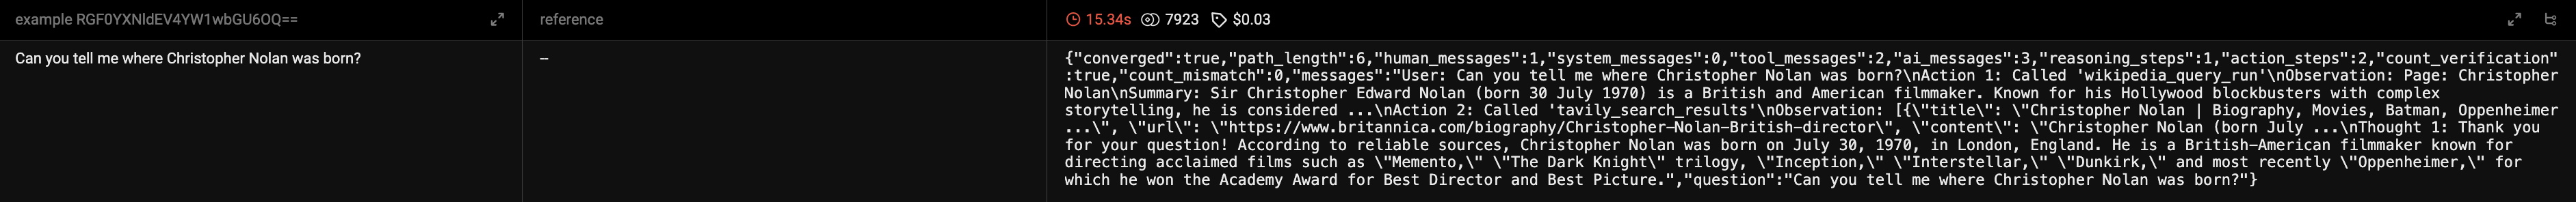

### Q: Where in the world was Christopher Nolan born?
#### Path Length = 8 (Prev. 10) 
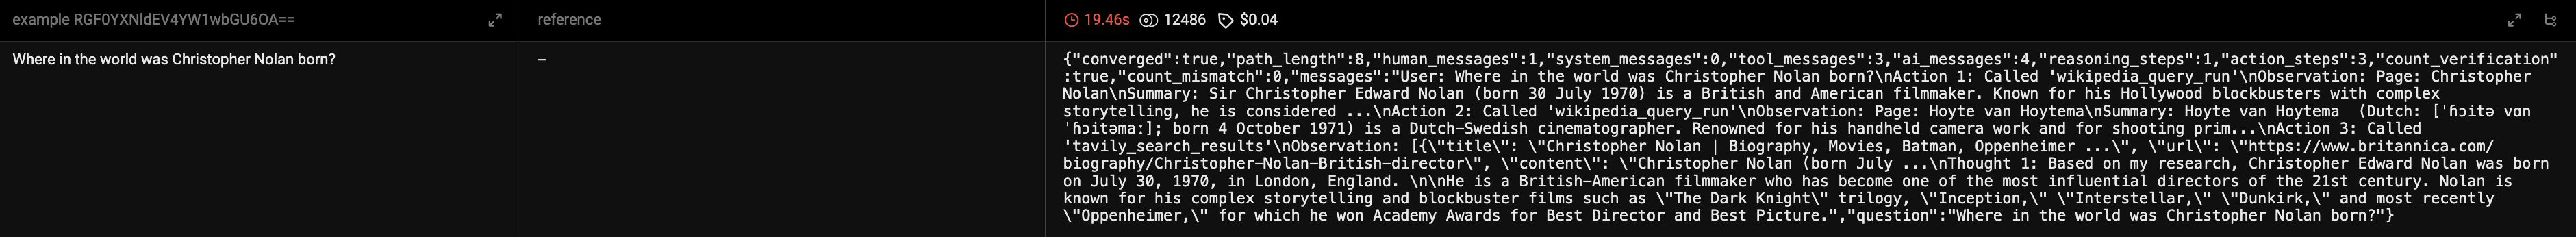

# Q&A on Retrieved Data
## When To Use Q&A Eval Template

This Eval evaluates whether a question was correctly answered by the system based on the retrieved data. In contrast to retrieval Evals that are checks on chunks of data returned, this check is a system level check of a correct Q&A.

    question: This is the question the Q&A system is running against

    sampled_answer: This is the answer from the Q&A system.

    context: This is the context to be used to answer the question, and is what Q&A Eval must use to check the correct answer

Source: https://arize.com/docs/phoenix/evaluation/how-to-evals/running-pre-tested-evals/q-and-a-on-retrieved-data

## Wikipedia dataset (synthetic) 

In [45]:
# Create the final DataFrame with wiki inputs, detailed contextual references, and spans outputs
data = {
    'question': [
        "Which actor played the main character in the TV series Breaking Bad?",
        "What is the capital of France?",
        "Who wrote the novel \"1984\"?",
        "What is the chemical symbol for gold?",
        "Which planet is known as the Red Planet?",
        "Who painted the Mona Lisa?",
        "What is the largest ocean on Earth?",
        "In which year did World War II end?",
        "What is the speed of light in a vacuum?",
        "Who composed \"The Four Seasons\"?"
    ],
    'context': [
        "Bryan Cranston portrayed Walter White, the protagonist of Breaking Bad, a critically acclaimed television series that aired from 2008 to 2013. The character is a high school chemistry teacher in Albuquerque, New Mexico, who turns to manufacturing and selling methamphetamine after being diagnosed with lung cancer. Cranston's performance earned him four consecutive Emmy Awards for Outstanding Lead Actor in a Drama Series.",
        "Paris is the capital and most populous city of France, with an estimated population of 2.1 million residents within the city proper and over 12 million in the metropolitan area. Located in northern central France on the Seine River, Paris has been a major European city for over two millennia and serves as the country's political, economic, cultural, and artistic center. The city is known for landmarks like the Eiffel Tower, Louvre Museum, and Notre-Dame Cathedral.",
        "George Orwell, born Eric Arthur Blair in 1903, wrote the dystopian social science fiction novel \"Nineteen Eighty-Four\" which was published in 1949. The novel presents a totalitarian society ruled by Big Brother and the Party, featuring concepts like thoughtcrime, doublethink, and the Thought Police. The book introduced terms like \"Big Brother,\" \"thoughtcrime,\" and \"doublespeak\" into popular culture and remains one of the most influential works of the 20th century.",
        "Gold's chemical symbol is Au, derived from the Latin word \"aurum\" meaning \"shining dawn.\" Gold is a chemical element with atomic number 79, making it one of the higher atomic number elements that occur naturally. It is a dense, soft, malleable, and ductile metal with a bright yellow color and luster that has been considered precious throughout human history due to its rarity, beauty, and resistance to tarnish.",
        "Mars is known as the Red Planet due to its reddish appearance, which results from iron oxide (commonly known as rust) prevalent on its surface. Mars is the fourth planet from the Sun and the second-smallest planet in the Solar System, with a diameter roughly half that of Earth. The planet has been a subject of human interest for millennia and is a primary target for space exploration, with numerous robotic missions having been sent to study its surface and atmosphere.",
        "Leonardo da Vinci painted the Mona Lisa (La Gioconda) between 1503 and 1519 during the Italian Renaissance. The portrait depicts Lisa Gherardini, believed to be the wife of a Florentine merchant. The painting is renowned for the subject's enigmatic smile and da Vinci's pioneering painting techniques, including sfumato. Currently housed in the Louvre Museum in Paris, it is considered the world's most famous painting and attracts millions of visitors annually.",
        "The Pacific Ocean is the largest and deepest ocean basin on Earth, covering approximately 63 million square miles (165 million square kilometers), which is about one-third of the planet's surface and larger than all land areas combined. It contains more than half of the free water on Earth and extends from the Arctic Ocean in the north to the Southern Ocean in the south, bounded by Asia and Australia on the west and the Americas on the east.",
        "World War II ended in 1945 with two distinct surrender dates: May 8, 1945 (Victory in Europe Day or VE Day) marked the end of the war in Europe when Nazi Germany surrendered unconditionally, and September 2, 1945 (Victory over Japan Day or VJ Day) marked the end of the war in the Pacific when Japan formally surrendered aboard the USS Missouri in Tokyo Bay following the atomic bombings of Hiroshima and Nagasaki.",
        "The speed of light in a vacuum is exactly 299,792,458 meters per second (approximately 186,282 miles per second), which is a fundamental physical constant denoted by the letter c. This speed represents the upper limit for the speed at which matter, energy, or information can travel in the universe according to Einstein's theory of special relativity. The exact value was established by definition in 1983 when the meter was redefined in terms of the speed of light.",
        "Antonio Vivaldi composed \"The Four Seasons\" (Italian: Le quattro stagioni), a group of four violin concertos that are among the most popular pieces in the classical music repertoire. Written around 1720, each concerto represents a different season of the year and is accompanied by sonnets that describe the scenes depicted in the music. Vivaldi, known as \"Il Prete Rosso\" (The Red Priest), was a Baroque composer and virtuoso violinist who wrote over 500 concertos during his lifetime."
    ],
    'sampled_answer': [
        "Bryan Cranston played Walter White, the main character in Breaking Bad. He portrayed a high school chemistry teacher who becomes a methamphetamine manufacturer.",
        "The capital of France is Paris. It is the largest city in France and serves as the country's political, economic, and cultural center.",
        "George Orwell wrote the dystopian novel \"1984\". Published in 1949, it depicts a totalitarian society under constant surveillance.",
        "The chemical symbol for gold is Au, which comes from the Latin word \"aurum\" meaning gold.",
        "Mars is known as the Red Planet due to its reddish appearance, which comes from iron oxide (rust) on its surface.",
        "Leonardo da Vinci painted the Mona Lisa between 1503-1519. It is one of the most famous paintings in the world, housed in the Louvre Museum.",
        "The Pacific Ocean is the largest ocean on Earth, covering about one-third of the planet's surface and containing more than half of the free water on Earth.",
        "World War II ended in 1945. The war in Europe ended on May 8, 1945 (VE Day), and the war in the Pacific ended on September 2, 1945 after Japan's surrender.",
        "The speed of light in a vacuum is approximately 299,792,458 meters per second, often rounded to 3.00 × 10^8 m/s for calculations.",
        "Antonio Vivaldi composed \"The Four Seasons\" (Le quattro stagioni), a set of four violin concertos representing each season of the year."
    ]
}

# Create the DataFrame
wikiDF = pd.DataFrame(data)

In [46]:
wikiDF

,question,context,sampled_answer
0,Which actor played the main character in the T...,"Bryan Cranston portrayed Walter White, the pro...","Bryan Cranston played Walter White, the main c..."
1,What is the capital of France?,Paris is the capital and most populous city of...,The capital of France is Paris. It is the larg...
2,"Who wrote the novel ""1984""?","George Orwell, born Eric Arthur Blair in 1903,...","George Orwell wrote the dystopian novel ""1984""..."
3,What is the chemical symbol for gold?,"Gold's chemical symbol is Au, derived from the...","The chemical symbol for gold is Au, which come..."
4,Which planet is known as the Red Planet?,Mars is known as the Red Planet due to its red...,Mars is known as the Red Planet due to its red...
5,Who painted the Mona Lisa?,Leonardo da Vinci painted the Mona Lisa (La Gi...,Leonardo da Vinci painted the Mona Lisa betwee...
6,What is the largest ocean on Earth?,The Pacific Ocean is the largest and deepest o...,The Pacific Ocean is the largest ocean on Eart...
7,In which year did World War II end?,World War II ended in 1945 with two distinct s...,World War II ended in 1945. The war in Europe ...
8,What is the speed of light in a vacuum?,"The speed of light in a vacuum is exactly 299,...",The speed of light in a vacuum is approximatel...
9,"Who composed ""The Four Seasons""?","Antonio Vivaldi composed ""The Four Seasons"" (I...","Antonio Vivaldi composed ""The Four Seasons"" (L..."


# Prompt Template

In [47]:
QA_PROMPT_TEMPLATE = """
You are given a question, an answer and reference text. You must determine whether the
given answer correctly answers the question based on the reference text. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Reference]: {context}
    ************
    [Answer]: {sampled_answer}
    [END DATA]
Your response must be a single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"correct" means that the question is correctly and fully answered by the answer.
"incorrect" means that the question is not correctly or only partially answered by the
answer.
"""

In [48]:
 # phoenix.evals.templates.default_templates as templates
from phoenix.evals import (
    download_benchmark_dataset,
    QA_PROMPT_RAILS_MAP,
    llm_classify
)
model = AnthropicModel(
    model=MODEL,
    temperature=0,
    max_tokens=2000
)

#The rails fore the output to specific values of the template
#It will remove text such as ",,," or "...", anything not the
#binary value expected from the template
rails = list(QA_PROMPT_RAILS_MAP.values())
Q_and_A_classifications = llm_classify(
    dataframe=wikiDF,
    template=QA_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True, #optional to generate explanations for the value produced by the eval LLM
)

llm_classify |          | 0/10 (0.0%) | ⏳ 00:00<? | ?it/s

### While the (predicted) 'label' is correct, the model is repeating the label as the explanation...

In [49]:
Q_and_A_classifications

,label,explanation,exceptions,execution_status,execution_seconds
0,correct,correct,[],COMPLETED,21.479378
1,correct,correct,[],COMPLETED,8.147937
2,correct,correct,[],COMPLETED,7.571866
3,correct,correct,[],COMPLETED,6.321456
4,correct,correct,[],COMPLETED,5.539817
5,correct,correct,[],COMPLETED,12.002892
6,correct,correct,[],COMPLETED,11.838240
7,correct,correct,[],COMPLETED,10.402615
8,correct,correct,[],COMPLETED,4.258100
9,correct,correct,[],COMPLETED,8.346372


In [50]:
Q_and_A_classifications[Q_and_A_classifications.index == 0] ['explanation'].values

array(['correct'], dtype=object)

In [51]:
wikiDF[wikiDF.index == 0] ['question'].values

array(['Which actor played the main character in the TV series Breaking Bad?'],
      dtype=object)

In [52]:
wikiDF[wikiDF.index == 0] ['sampled_answer'].values

array(['Bryan Cranston played Walter White, the main character in Breaking Bad. He portrayed a high school chemistry teacher who becomes a methamphetamine manufacturer.'],
      dtype=object)

In [53]:
wikiDF[wikiDF.index == 0] ['context'].values

array(["Bryan Cranston portrayed Walter White, the protagonist of Breaking Bad, a critically acclaimed television series that aired from 2008 to 2013. The character is a high school chemistry teacher in Albuquerque, New Mexico, who turns to manufacturing and selling methamphetamine after being diagnosed with lung cancer. Cranston's performance earned him four consecutive Emmy Awards for Outstanding Lead Actor in a Drama Series."],
      dtype=object)

In [54]:
Q_and_A_classifications[Q_and_A_classifications.index == 8] ['explanation'].values

array(['correct'], dtype=object)

In [55]:
wikiDF[wikiDF.index == 8] ['question'].values

array(['What is the speed of light in a vacuum?'], dtype=object)

In [56]:
wikiDF[wikiDF.index == 8] ['sampled_answer'].values

array(['The speed of light in a vacuum is approximately 299,792,458 meters per second, often rounded to 3.00 × 10^8 m/s for calculations.'],
      dtype=object)

In [57]:
wikiDF[wikiDF.index == 8] ['context'].values

array(["The speed of light in a vacuum is exactly 299,792,458 meters per second (approximately 186,282 miles per second), which is a fundamental physical constant denoted by the letter c. This speed represents the upper limit for the speed at which matter, energy, or information can travel in the universe according to Einstein's theory of special relativity. The exact value was established by definition in 1983 when the meter was redefined in terms of the speed of light."],
      dtype=object)